# **Programming for Applied Deep Learning (GKSG008-01)**
> ### **20181202 김수미**
> ### LeNet_with_Conv2d(3) (Based on 11/18 Lecture)

3. Try CIFAR100:  https://pytorch.org/vision/stable/datasets.html#cifar
- The same shape as CIFAR-10, but it has 100 classes.
- Modify your code (the last linear layer) so that it may produce score vectors of size 100.

**◦ Import Libraries and Define Functions.**

In [ ]:
pip install d2l

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as data
import warnings
warnings.filterwarnings('ignore')

from d2l.torch import *
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
def load_data_cifar100(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
      trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.CIFAR100(root="../data",train=True,transform=trans,download=True)
    mnist_test = torchvision.datasets.CIFAR100(root="../data",train=False,transform=trans,download=True)
    return(data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4),
           data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=4))

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)

  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [5]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  print('training on', device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)

  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
    
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

**◦ Load Dataset.**

In [ ]:
batch_size = 128
train_iter, test_iter = load_data_cifar100(batch_size)

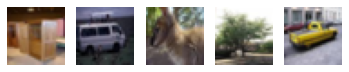

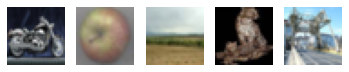

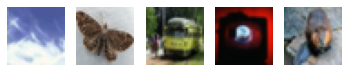

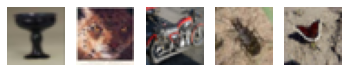

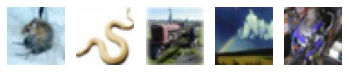

In [7]:
label = 0; images = []
for data in train_iter:
  x,y = data
  for j in y:
    if j.item() == label:
      images.append(x[0])
      label += 1
      break
  if label == 100: break

fig1 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig1.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

fig2 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig2.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i+5].permute(1, 2, 0))
  ax1.axis("off")
plt.show()


fig3 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig3.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i+10].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

fig4 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig4.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i+15].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

fig5 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig5.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i+20].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

**< CIFAR100 Lables >**

0   | Superclass         | Classes
----|--------------------|------------------
1 | aquatic mammals	| beaver, dolphin, otter, seal, whale
2 | fish	| aquarium fish, flatfish, ray, shark, trout
3 | flowers	| orchids, poppies, roses, sunflowers, tulips
4 | food | containers	bottles, bowls, cans, cups, plates
5 | fruit and vegetables | apples, mushrooms, oranges, pears, sweet peppers
6 | household electrical devices | clock, computer keyboard, lamp, telephone, television
7 | household furniture	| bed, chair, couch, table, wardrobe
8 | insects	| bee, beetle, butterfly, caterpillar, cockroach
9 | large carnivores |	bear, leopard, lion, tiger, wolf
10 | large man-made outdoor things	| bridge, castle, house, road, skyscraper
11 | large natural outdoor scenes	| cloud, forest, mountain, plain, sea
12 | large omnivores and herbivores	| camel, cattle, chimpanzee, elephant, kangaroo
13 | medium-sized mammals	| fox, porcupine, possum, raccoon, skunk
14 | non-insect invertebrates	| crab, lobster, snail, spider, worm
15 | people	| baby, boy, girl, man, woman
16 | reptiles |	crocodile, dinosaur, lizard, snake, turtle
17 | small mammals	| hamster, mouse, rabbit, shrew, squirrel
18 | trees	| maple, oak, palm, pine, willow
19 | vehicles 1	| bicycle, bus, motorcycle, pickup truck, train
20 | vehicles 2	| lawn-mower, rocket, streetcar, tank, tractor

<br>

**◦ Construct network for CIFAR100 dataset based on LeNet.**

In [8]:
# modified parameters
my_net = nn.Sequential(nn.Conv2d(3, 16, kernel_size=5, padding=2),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size=2, stride=2),
                       nn.Conv2d(16, 32, kernel_size=5),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size=2, stride=2),
                       nn.Flatten(),
                       nn.Linear(1152, 500), 
                       nn.ReLU(),
                       nn.Linear(500, 250),
                       nn.Sigmoid(),
                       nn.Linear(250, 100))

X = torch.rand(size=(1, 3, 32, 32), dtype=torch.float32)
for layer in my_net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 16, 32, 32])
ReLU output shape:	 torch.Size([1, 16, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 16, 16, 16])
Conv2d output shape:	 torch.Size([1, 32, 12, 12])
ReLU output shape:	 torch.Size([1, 32, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 32, 6, 6])
Flatten output shape:	 torch.Size([1, 1152])
Linear output shape:	 torch.Size([1, 500])
ReLU output shape:	 torch.Size([1, 500])
Linear output shape:	 torch.Size([1, 250])
Sigmoid output shape:	 torch.Size([1, 250])
Linear output shape:	 torch.Size([1, 100])


**◦ Training Result**

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

loss 2.442, train acc 0.370, test acc 0.279
4207.5 examples/sec on cuda:0


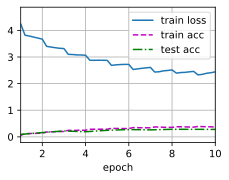

In [9]:
# modified num_epochs (100->50)
# Takes about 2 min
lr, num_epochs = 0.6, 10
train_ch6(my_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())